In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# GPUが利用可能か確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# データの前処理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNISTデータセットの読み込み
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# CNNネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンス化とGPUへの移動
net = Net()
net.to(device)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# モデルのトレーニング
for epoch in range(10):  # エポック数を調整
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # データとラベルをGPUに送る
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Finished Training')

# テストデータでの精度を計算
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # データとラベルをGPUに送る
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct / total}%')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Loss: 0.8581155929913018
Epoch 2, Loss: 0.2081071079245953
Epoch 3, Loss: 0.13486914363489158
Epoch 4, Loss: 0.10271559043455797
Epoch 5, Loss: 0.08509253144417125
Epoch 6, Loss: 0.07366282478677852
Epoch 7, Loss: 0.0658151869779266
Epoch 8, Loss: 0.06001449331019654
Epoch 9, Loss: 0.054830324239353696
Epoch 10, Loss: 0.050768283971978516
Finished Training
Accuracy on test images: 98.35%


In [2]:
class SaveFeatures:
    features = None

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

In [3]:
def grad_cam(model, img, target_class):
    # 指定したクラスに対する勾配を取得するためのフックを設定
    target_layer = model.conv2
    feature_hook = SaveFeatures(target_layer)
    
    # モデルの順伝搬を実行
    logits = model(img)
    model.zero_grad()
    logits.requires_grad_(True)
    
    gradients = feature_hook.features  # 勾配情報を取得
    gradients.retain_grad()  # 勾配情報を保持
    
    # 指定したクラスに対する勾配を計算
    logits[0, target_class].backward()
    
    # 勾配情報と特徴マップを取得
    gradients = feature_hook.features.grad
    activations = feature_hook.features
    #print(activations.shape)
    #print(gradients.shape)
    
    # Global Average Pooling (GAP)を計算
    alpha = torch.mean(gradients, dim=(1, 2), keepdim=True)
    #print(alpha.shape)
    #print((alpha*activations).shape)
    
    # 重みを特徴マップに適用してGrad-CAMを生成
    #grad_cam = torch.sum(alpha * activations, dim=0)
    grad_cam = torch.sum(alpha * activations, dim=(0), keepdim=True)
    #print(grad_cam[0].shape)
    
    # ReLUを適用して負の値を0にクリップ
    grad_cam = nn.functional.relu(grad_cam)
    
    # Grad-CAMを画像サイズにリサイズ
    grad_cam = nn.functional.interpolate(grad_cam.unsqueeze(0), size=img.shape[-2:], mode='bilinear', align_corners=False)
    
    return grad_cam[0]

In [7]:
i = 0
for data in testloader:
    images, labels = data
    images.requires_grad_(True)
    images, labels = images.to(device), labels.to(device)  # データとラベルをGPUに送る
    grad_cam_map = grad_cam(net, images[0], labels[0])
    i += 1
    if i == 4:
        break

In [8]:
import matplotlib.pyplot as plt
import numpy

# 画像とGrad-CAMマップを表示する関数
def visualize_grad_cam(grad_cam_map, original_image):
    plt.figure(figsize=(12, 4))
    
    # 元の画像を表示
    plt.subplot(1, 2, 1)
    original_image = original_image.cpu().detach().numpy().squeeze()  # 次元を削除
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    
    # Grad-CAMマップを表示
    plt.subplot(1, 2, 2)
    grad_cam_map = grad_cam_map.cpu().detach().numpy().squeeze()  # 次元を削除
    plt.imshow(grad_cam_map, cmap='jet')
    plt.title("Grad-CAM Map")
    
    plt.tight_layout()
    plt.show()

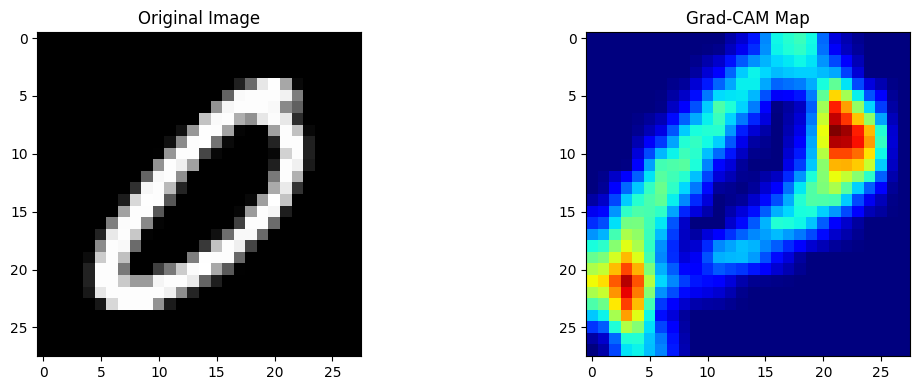

In [9]:
visualize_grad_cam(grad_cam_map, images[0])